In [ ]:
"""This is an implementation from scratch of logistic regression for multi-class image classification on the ForestNet dataset. 
was completed using various pieces of online research."""

In [1]:
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

<IPython.core.display.Javascript object>

/Users/uochuba/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/uochuba/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/uochuba/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <7013222E-BE83-37D3-A6A7-75922143299C> /Users/uochuba/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [92]:
# Hyperparameters
batch_size = 8
learning_rate = 1e-5

# Other constants
input_size = 128*128*3
num_classes = 4

In [28]:
# os.chdir('Documents/Stanford/Senior/CS229/LR_baseline/tree_sheet.csv')
dataset = pd.read_csv('train_128_sheet.csv')
valdataset = pd.read_csv('val_128_sheet.csv')
testdataset = pd.read_csv('test_128_sheet.csv')
num_rows = dataset.shape[0]
# To map each label number to its corresponding letter
id2label = {0: 'Grassland shrubland', 1: 'Other', 2: 'Plantation', 3: 'Smallholder agriculture'}

In [29]:
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel49142,pixel49143,pixel49144,pixel49145,pixel49146,pixel49147,pixel49148,pixel49149,pixel49150,pixel49151
0,0,12,23,9,12,23,9,12,23,9,...,21,36,39,22,35,39,22,35,39,22
1,0,22,35,17,23,36,18,23,36,18,...,29,35,47,33,34,46,32,29,41,27
2,0,75,79,65,57,61,47,37,41,27,...,16,16,23,15,13,18,12,10,15,9
3,0,17,26,7,18,27,8,20,29,10,...,14,26,28,14,26,28,14,26,28,14
4,0,22,33,17,24,35,19,25,36,20,...,6,9,17,6,9,17,6,9,17,6


In [30]:
def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [31]:
inputs_array, targets_array = dataframe_to_array(dataset)
valinputs_array, valtargets_array = dataframe_to_array(valdataset)
testinputs_array, testtargets_array = dataframe_to_array(testdataset)

In [32]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).long()
valinputs = torch.from_numpy(valinputs_array).float()
valtargets = torch.from_numpy(valtargets_array).long()
testinputs = torch.from_numpy(testinputs_array).float()
testtargets = torch.from_numpy(testtargets_array).long()

In [93]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
valdataset = TensorDataset(valinputs, valtargets)
testdataset = TensorDataset(testinputs, testtargets)

# Dataloaders
train_loader = DataLoader(dataset, batch_size, shuffle=True)
val_loader = DataLoader(valdataset, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

In [94]:
class LRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 49152)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [95]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [96]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [141]:
model = LRModel()

In [142]:
evaluate(model, val_loader)

{'val_loss': 18.072843551635742, 'val_acc': 0.12916666269302368}

In [143]:
history = fit(200, 1e-8, model, train_loader, val_loader)

Epoch [0], val_loss: 5.0372, val_acc: 0.2824
Epoch [1], val_loss: 5.0431, val_acc: 0.2882
Epoch [2], val_loss: 4.9679, val_acc: 0.2928
Epoch [3], val_loss: 4.9181, val_acc: 0.2991
Epoch [4], val_loss: 4.9220, val_acc: 0.2907
Epoch [5], val_loss: 4.8273, val_acc: 0.2949
Epoch [6], val_loss: 4.8537, val_acc: 0.2907
Epoch [7], val_loss: 4.7813, val_acc: 0.2970
Epoch [8], val_loss: 4.7438, val_acc: 0.2970
Epoch [9], val_loss: 4.7285, val_acc: 0.2907
Epoch [10], val_loss: 4.6984, val_acc: 0.2949
Epoch [11], val_loss: 4.6782, val_acc: 0.2970
Epoch [12], val_loss: 4.6601, val_acc: 0.3095
Epoch [13], val_loss: 4.6716, val_acc: 0.2949
Epoch [14], val_loss: 4.6219, val_acc: 0.3053
Epoch [15], val_loss: 4.6065, val_acc: 0.3053
Epoch [16], val_loss: 4.5902, val_acc: 0.3074
Epoch [17], val_loss: 4.5641, val_acc: 0.3032
Epoch [18], val_loss: 4.5779, val_acc: 0.3012
Epoch [19], val_loss: 4.5398, val_acc: 0.3095
Epoch [20], val_loss: 4.5404, val_acc: 0.3053
Epoch [21], val_loss: 4.5117, val_acc: 0.311

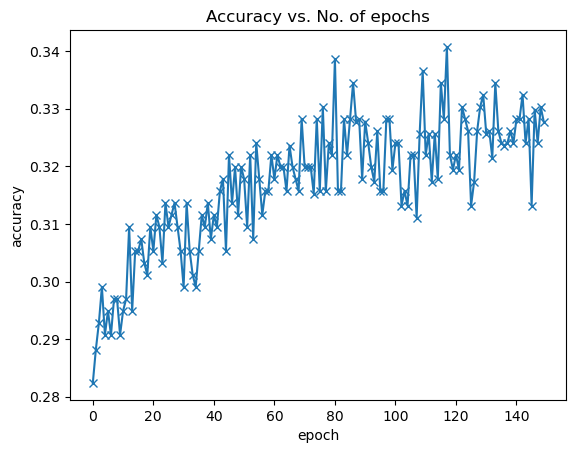

In [144]:
accuracies = [r['val_acc'] for r in history[:150]]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

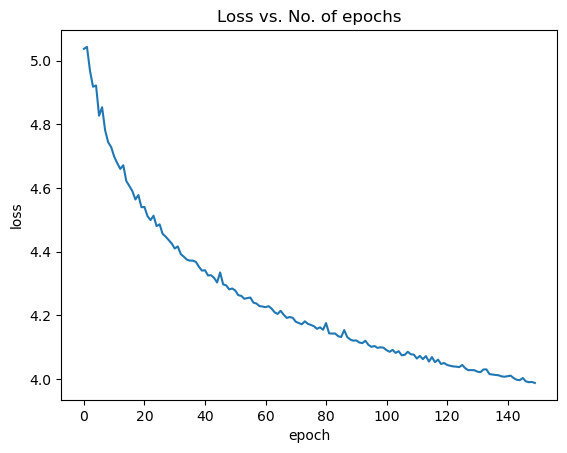

In [145]:
losses = [r['val_loss'] for r in history[:150]]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [148]:
model = LRModel()

In [149]:
evaluate(model, val_loader)

{'val_loss': 28.54311752319336, 'val_acc': 0.13958333432674408}

In [150]:
history = fit(200, 1e-9, model, train_loader, val_loader)

Epoch [0], val_loss: 23.1050, val_acc: 0.1396
Epoch [1], val_loss: 17.8246, val_acc: 0.1333
Epoch [2], val_loss: 13.1142, val_acc: 0.1396
Epoch [3], val_loss: 9.5587, val_acc: 0.1562
Epoch [4], val_loss: 7.3238, val_acc: 0.1979
Epoch [5], val_loss: 6.1865, val_acc: 0.2475
Epoch [6], val_loss: 5.6703, val_acc: 0.2620
Epoch [7], val_loss: 5.4240, val_acc: 0.2907
Epoch [8], val_loss: 5.3048, val_acc: 0.3111
Epoch [9], val_loss: 5.2426, val_acc: 0.3194
Epoch [10], val_loss: 5.2097, val_acc: 0.3236
Epoch [11], val_loss: 5.1920, val_acc: 0.3257
Epoch [12], val_loss: 5.1824, val_acc: 0.3299
Epoch [13], val_loss: 5.1764, val_acc: 0.3382
Epoch [14], val_loss: 5.1731, val_acc: 0.3340
Epoch [15], val_loss: 5.1708, val_acc: 0.3340
Epoch [16], val_loss: 5.1687, val_acc: 0.3340
Epoch [17], val_loss: 5.1669, val_acc: 0.3319
Epoch [18], val_loss: 5.1649, val_acc: 0.3319
Epoch [19], val_loss: 5.1630, val_acc: 0.3315
Epoch [20], val_loss: 5.1606, val_acc: 0.3294
Epoch [21], val_loss: 5.1582, val_acc: 0.

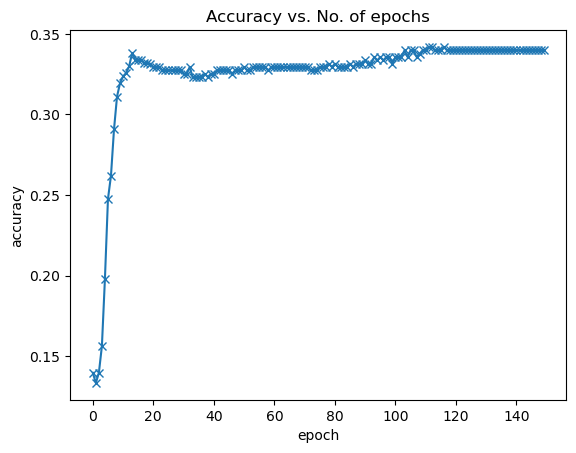

In [151]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

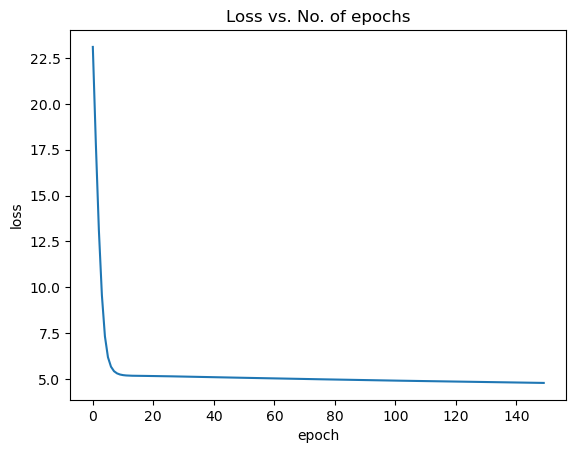

In [152]:
losses = [r['val_loss'] for r in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [154]:
result_2 = evaluate(model, test_loader)
result_2

{'val_loss': 4.4800591468811035, 'val_acc': 0.3333333432674408}